# Expected Goals (xG) Model - 02

In [1]:
import json
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
import xarray as xr
import bambi as bmb

import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sns

%load_ext dotenv
%dotenv
PROJECT_DIR=Path(os.environ.get('PROJECT_DIR'))
sys.path.append(str(PROJECT_DIR))

import projects.common.xg.scr.FCPython as FCPython
from projects.common.xg.scr.data_prep import make_data, stack_qcuts, calc_dist, calc_angle

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

theme_set(theme_bw())
pd.set_option('display.max_columns', 100)
# working with arviz structure?
xr.set_options(display_expand_data=False, display_expand_attrs=False, display_expand_coords=False,
              display_expand_data_vars=False)
SEED = 1925

DATA_FILEPATH = PROJECT_DIR / 'data'  / 'bigger-data' / 'football' / 'events' / 'events_England.json' 
DATA_FILEPATH

PosixPath('/media/david/T7/code/bmcp/bmcp-notes/data/bigger-data/football/events/events_England.json')

# Estimate xG from Data
+ Probability that a shot becomes a goal, relative to the position of the shot on the pitch.
+ Better predictor of future performance than goals scored
+ Accounts for luck/randomness

In [3]:
df_orig = make_data(DATA_FILEPATH)
df_orig = df_orig[['X', 'Y', 'C', 'Distance', 'Angle_deg', 'goal']]
df_orig = df_orig.rename(columns={'Angle_deg': 'Angle'})
df_orig.head()

,X,Y,C,Distance,Angle,goal
0,12,41,9,13.891814,27.184065,1
1,15,52,2,15.803560,26.002161,0
2,19,33,17,22.805811,16.077018,0
3,25,30,20,29.292704,12.815892,0
4,10,39,11,12.703248,27.447608,0


In [4]:
shots_df = df_orig.copy()
H_Shot=np.histogram2d(shots_df['X'], shots_df['Y'],bins=50,range=[[0, 100],[0, 100]])
goals_only=shots_df[shots_df['goal']==1]
H_Goal=np.histogram2d(goals_only['X'], goals_only['Y'],bins=50,range=[[0, 100],[0, 100]])
# Divide warning
prob_goal = H_Goal[0]/H_Shot[0]

/tmp/ipykernel_178622/3599928122.py:6: RuntimeWarning: invalid value encountered in true_divide


## Number of Shots

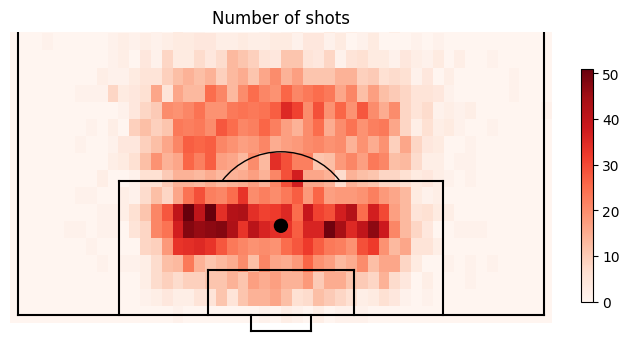

In [5]:
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title('Number of shots')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show();

## Number of Goals

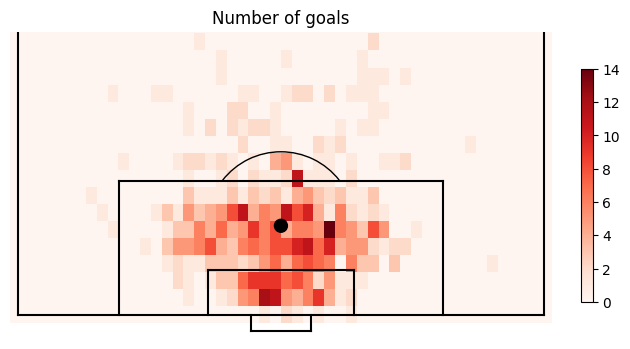

In [6]:
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title('Number of goals')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show(); 

## Probability of a Goal

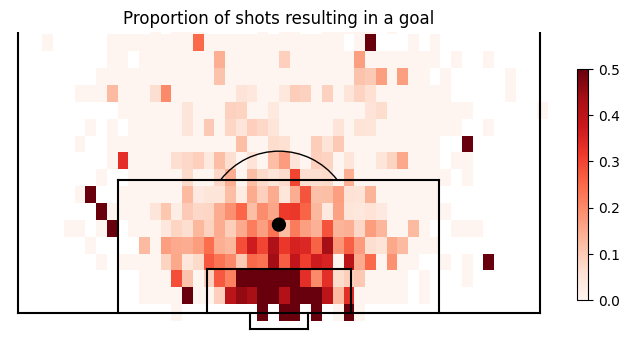

In [7]:
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(prob_goal, extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title('Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show();

## Probability of Goal with Minimum Number of Shots Threshold

/tmp/ipykernel_178622/2563741558.py:4: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_178622/2563741558.py:4: RuntimeWarning: invalid value encountered in true_divide


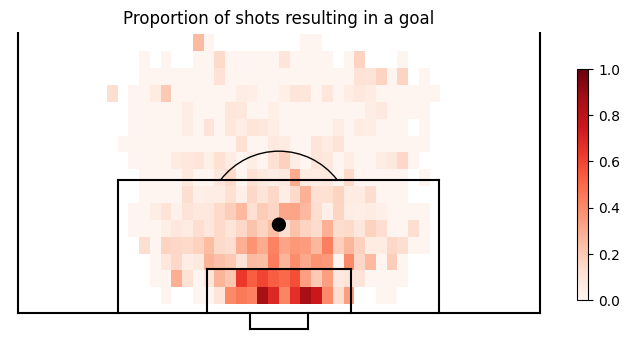

In [8]:
min_n_shots = 4
h_shots = H_Shot[0]
h_shots[h_shots < min_n_shots] = 0
prob_goal = H_Goal[0]/h_shots

(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(prob_goal, extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=1.0)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title('Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Shot Geometry

In [9]:
dist_pitchmap = np.zeros((65, 65))
angle_pitchmap = np.zeros((65, 65))
combo_pitchmap = np.zeros((65, 65, 2))
for x in range(65):
    for y in range(65):
        dist_pitchmap[x,y] = calc_dist(x, y)
        angle_pitchmap[x,y] = calc_angle(x, y)
        combo_pitchmap[x, y] = np.array([calc_dist(x,y), calc_angle(x, y)])

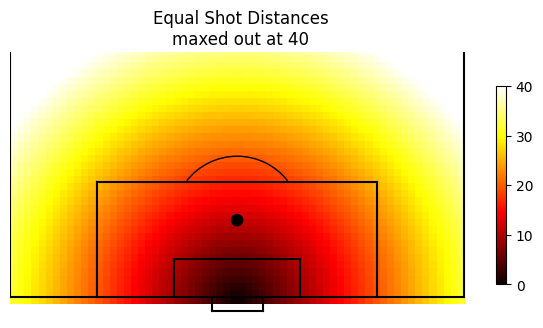

In [10]:
(fig,ax) = FCPython.createGoalMouth()
vmax = 40
pos=ax.imshow(dist_pitchmap, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.hot,vmin=0, vmax=vmax)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title(f'Equal Shot Distances\nmaxed out at {vmax}')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

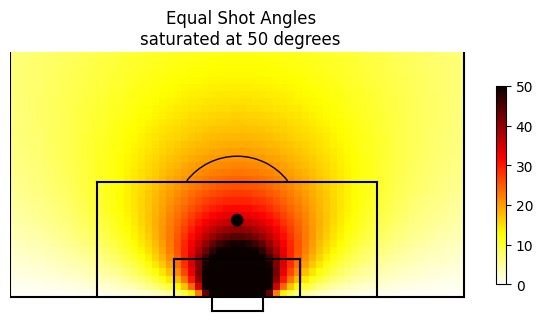

In [11]:
(fig,ax) = FCPython.createGoalMouth()
vmax = 50
pos=ax.imshow(angle_pitchmap, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.hot_r,vmin=0, vmax=vmax)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title(f'Equal Shot Angles\nsaturated at {vmax} degrees')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Relationship Between Shot Geometry and Probability of Scoring a Goal

In [12]:
df_rel = df_orig.copy()
n_quantiles = 20
qcut_vars = ['X', 'Y', 'C', 'Distance', 'Angle']
prop_on_col='goal'

df_stacked_qcuts = stack_qcuts(df_rel, qcut_vars, prop_on_col=prop_on_col, n_quantiles=n_quantiles)
df_stacked_qcuts[df_stacked_qcuts['variable']=='Distance'].head()

,index,bin,goal,prob_goal,variable,midpoint
60,0,"(1.2340000000000002, 7.796]",1,0.458333,Distance,4.5150
61,1,"(7.796, 10.236]",1,0.260274,Distance,9.0160
62,2,"(10.236, 11.717]",1,0.200557,Distance,10.9765
63,3,"(11.717, 12.865]",1,0.178470,Distance,12.2910
64,4,"(12.865, 13.789]",1,0.168044,Distance,13.3270


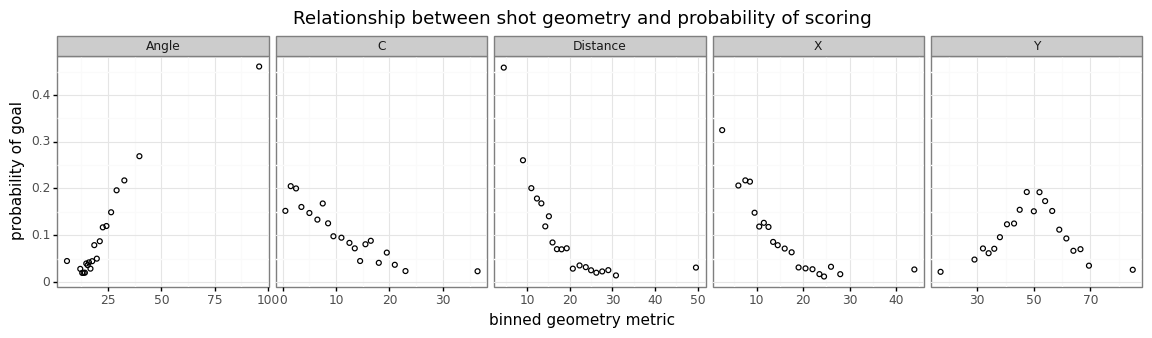

In [13]:
p = (ggplot(df_stacked_qcuts, aes(x='midpoint', y='prob_goal')) +
     geom_point(fill='none') +
     facet_wrap('variable', nrow=1, scales='free_x') +
     theme(figure_size=(14, 3)) +
     labs(x='binned geometry metric', y='probability of goal', title='Relationship between shot geometry and probability of scoring')
    )
p.draw();

In [14]:
dfm = df_orig.copy()[['Angle', 'C', 'Distance', 'X', 'Y', 'goal']]
dfm.head()

,Angle,C,Distance,X,Y,goal
0,27.184065,9,13.891814,12,41,1
1,26.002161,2,15.803560,15,52,0
2,16.077018,17,22.805811,19,33,0
3,12.815892,20,29.292704,25,30,0
4,27.447608,11,12.703248,10,39,0


In [15]:
dfm.describe()

,Angle,C,Distance,X,Y,goal
count,7134.000000,7134.000000,7134.000000,7134.000000,7134.000000,7134.000000
mean,22.016715,11.871040,19.562316,16.303196,48.784973,0.103168
std,13.062987,7.496299,7.742471,7.755600,13.987829,0.304199
min,-0.000000,0.000000,1.234909,0.000000,7.000000,0.000000
25%,14.394605,6.000000,13.788582,10.000000,37.000000,0.000000
50%,17.967114,12.000000,18.576396,15.000000,49.000000,0.000000
75%,25.246505,17.000000,25.596924,23.000000,60.000000,0.000000
max,147.077669,49.000000,67.184838,59.000000,99.000000,1.000000


# Distance Model

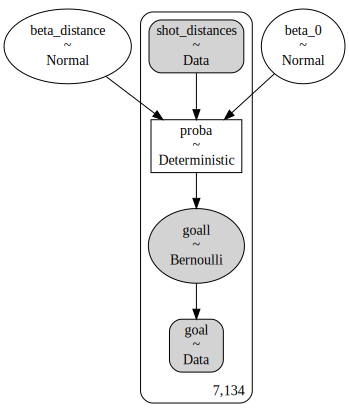

In [16]:
X_obs = dfm['Distance'].values
goal_obs = pd.Categorical(dfm['goal']).codes

with pm.Model() as distance_model:
    beta_0 = pm.Normal('beta_0', mu=0, sigma=1.5)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=0.05)
    
    # Add observed data as pm.Data for more flexibility later
    # Data must be same type to swap out cannot mix ints and floats
    shot_distances = pm.Data('shot_distances', X_obs)
    goal_obs = pm.Data('goal', goal_obs)

    # mu = beta_0 + pm.math.dot(shot_distances, beta_distance)
    mu = beta_0 + beta_distance* shot_distances
    
    proba = pm.Deterministic('proba', pm.math.sigmoid(mu))
    
    goall = pm.Bernoulli('goall', p=proba, observed=goal_obs)
    
    prior_pred = pm.sample_prior_predictive()

    idata_distance = az.from_pymc3(prior=prior_pred)

# idata_distance.to_netcdf(DATA_FILEPATH.parent / 'distance_azobj_prior.nc')
pm.model_to_graphviz(distance_model)

## Prior Predictive Check

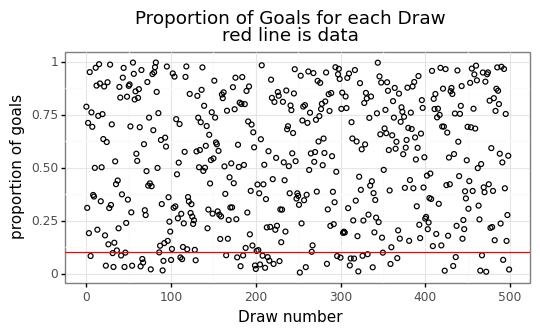

In [17]:
data_propgoal = len(df_orig[df_orig['goal']==1]) / len(df_orig)

goals = idata_distance.prior_predictive['goall'].to_dataframe().reset_index()
goals = pd.DataFrame(goals.groupby(by=['draw'])['goall'].sum() / goals.groupby(by=['draw'])['goall'].count()).reset_index()
goals = goals.rename(columns={'goall': 'proportion_goals'}) 
p = (ggplot(goals, aes(x='draw', y='proportion_goals')) +
     geom_point(fill='none') +
     geom_hline(yintercept = data_propgoal, color='red') +
     labs(x='Draw number', y='proportion of goals', title='Proportion of Goals for each Draw\nred line is data') +
     theme(figure_size=(6,3))
    )
p.draw();

In [18]:
n_draws = 1000
# Occasionally getting:
# - The acceptance probability does not match the target.
# - It is 0.xx but should be close to 0.8.
# - Try to increase the number of tuning steps.
# hence lifting tuning 1000 > 2000 and setting seed for reproducibility
n_tune = 2000

with distance_model:
    posterior_trace = pm.sample(n_draws, tune=n_tune, return_inferencedata=False, random_seed=1915)
    posterior_predictive = pm.sample_posterior_predictive(posterior_trace)
    idata_distance.extend(az.from_pymc3(trace=posterior_trace, posterior_predictive=posterior_predictive))
# idata_distance.to_netcdf(DATA_FILEPATH.parent / 'distance_azobj_posterior.nc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_distance, beta_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8815703097681247, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [19]:
idata_distance

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> constant_data

In [20]:
az.loo(idata_distance)

Computed from 4000 by 7134 log-likelihood matrix

         Estimate       SE
elpd_loo -2013.11    52.39
p_loo        2.50        -

# Distance Angle Model

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


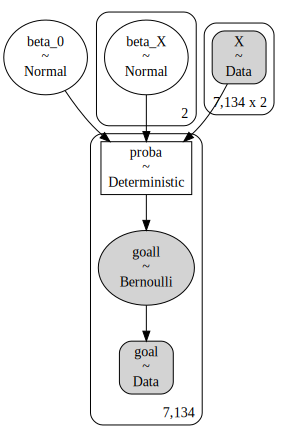

In [27]:
X_obs = dfm[['Distance', 'Angle']].values
goal_obs = pd.Categorical(dfm['goal']).codes

with pm.Model() as distance_angle_model:
    beta_0 = pm.Normal('beta_0', mu=0, sigma=1.5)
    beta_X = pm.Normal('beta_X', mu=0, sigma=0.05, shape=2)
    
    X = pm.Data('X', X_obs)
    goal_obs = pm.Data('goal', goal_obs)

    mu = beta_0 + pm.math.dot(X, beta_X)
    
    proba = pm.Deterministic('proba', pm.math.sigmoid(mu))
    
    goall = pm.Bernoulli('goall', p=proba, observed=goal_obs)
    
    prior_pred = pm.sample_prior_predictive()

    idata_distance_angle = az.from_pymc3(prior=prior_pred)

# idata_distance_angle.to_netcdf(DATA_FILEPATH.parent / 'distance_azobj_prior.nc')
pm.model_to_graphviz(distance_angle_model)

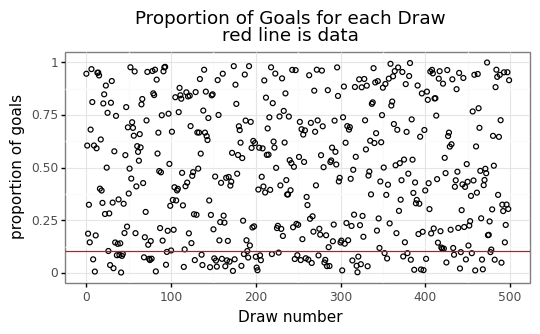

In [28]:
data_propgoal = len(df_orig[df_orig['goal']==1]) / len(df_orig)

goals = idata_distance_angle.prior_predictive['goall'].to_dataframe().reset_index()
goals = pd.DataFrame(goals.groupby(by=['draw'])['goall'].sum() / goals.groupby(by=['draw'])['goall'].count()).reset_index()
goals = goals.rename(columns={'goall': 'proportion_goals'}) 
p = (ggplot(goals, aes(x='draw', y='proportion_goals')) +
     geom_point(fill='none') +
     geom_hline(yintercept = data_propgoal, color='red') +
     labs(x='Draw number', y='proportion of goals', title='Proportion of Goals for each Draw\nred line is data') +
     theme(figure_size=(6,3))
    )
p.draw();

In [29]:
n_draws = 1000
# Occasionally getting:
# - The acceptance probability does not match the target.
# - It is 0.xx but should be close to 0.8.
# - Try to increase the number of tuning steps.
# hence lifting tuning 1000 > 2000 and setting seed for reproducibility
n_tune = 2000

with distance_angle_model:
    posterior_trace = pm.sample(n_draws, tune=n_tune, return_inferencedata=False, random_seed=1915)
    posterior_predictive = pm.sample_posterior_predictive(posterior_trace)
    idata_distance_angle.extend(az.from_pymc3(trace=posterior_trace, posterior_predictive=posterior_predictive))
# idata_distance_angle.to_netcdf(DATA_FILEPATH.parent / 'distance_azobj_posterior.nc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_X, beta_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 171 seconds.
The acceptance probability does not match the target. It is 0.9023762195147728, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [30]:
idata_distance_angle

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> constant_data

In [31]:
az.loo(idata_distance_angle)

Computed from 4000 by 7134 log-likelihood matrix

         Estimate       SE
elpd_loo -1994.11    51.98
p_loo        3.33        -

In [32]:
dfm.head()

,Angle,C,Distance,X,Y,goal
0,27.184065,9,13.891814,12,41,1
1,26.002161,2,15.803560,15,52,0
2,16.077018,17,22.805811,19,33,0
3,12.815892,20,29.292704,25,30,0
4,27.447608,11,12.703248,10,39,0


# Full Model

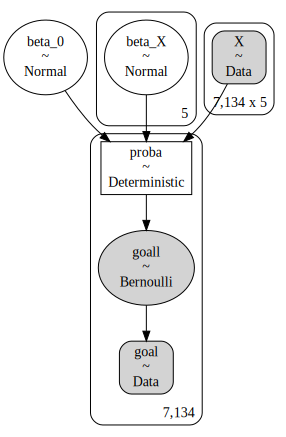

In [33]:
X_obs = dfm[['Distance', 'Angle', 'X', 'Y', 'C']].values
goal_obs = pd.Categorical(dfm['goal']).codes

with pm.Model() as full_model:
    beta_0 = pm.Normal('beta_0', mu=0, sigma=1.5)
    beta_X = pm.Normal('beta_X', mu=0, sigma=0.05, shape=5)
    
    X = pm.Data('X', X_obs)
    goal_obs = pm.Data('goal', goal_obs)

    mu = beta_0 + pm.math.dot(X, beta_X)
    
    proba = pm.Deterministic('proba', pm.math.sigmoid(mu))
    
    goall = pm.Bernoulli('goall', p=proba, observed=goal_obs)
    
    prior_pred = pm.sample_prior_predictive()

    idata_full = az.from_pymc3(prior=prior_pred)

# idata_full.to_netcdf(DATA_FILEPATH.parent / 'distance_azobj_prior.nc')
pm.model_to_graphviz(full_model)

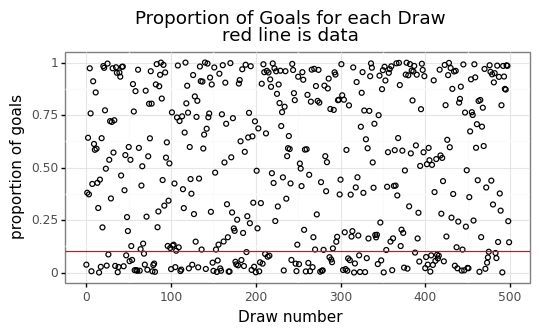

In [34]:
data_propgoal = len(df_orig[df_orig['goal']==1]) / len(df_orig)

goals = idata_full.prior_predictive['goall'].to_dataframe().reset_index()
goals = pd.DataFrame(goals.groupby(by=['draw'])['goall'].sum() / goals.groupby(by=['draw'])['goall'].count()).reset_index()
goals = goals.rename(columns={'goall': 'proportion_goals'}) 
p = (ggplot(goals, aes(x='draw', y='proportion_goals')) +
     geom_point(fill='none') +
     geom_hline(yintercept = data_propgoal, color='red') +
     labs(x='Draw number', y='proportion of goals', title='Proportion of Goals for each Draw\nred line is data') +
     theme(figure_size=(6,3))
    )
p.draw();

In [35]:
n_draws = 1000
# Occasionally getting:
# - The acceptance probability does not match the target.
# - It is 0.xx but should be close to 0.8.
# - Try to increase the number of tuning steps.
# hence lifting tuning 1000 > 2000 and setting seed for reproducibility
n_tune = 2000

with full_model:
    posterior_trace = pm.sample(n_draws, tune=n_tune, return_inferencedata=False, random_seed=1915)
    posterior_predictive = pm.sample_posterior_predictive(posterior_trace)
    idata_full.extend(az.from_pymc3(trace=posterior_trace, posterior_predictive=posterior_predictive))
# idata_distance_angle.to_netcdf(DATA_FILEPATH.parent / 'distance_azobj_posterior.nc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_X, beta_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 552 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [36]:
idata_full

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> constant_data

In [37]:
az.loo(idata_full)

Computed from 4000 by 7134 log-likelihood matrix

         Estimate       SE
elpd_loo -1993.95    52.14
p_loo        5.67        -

# Full plus Interactions Model

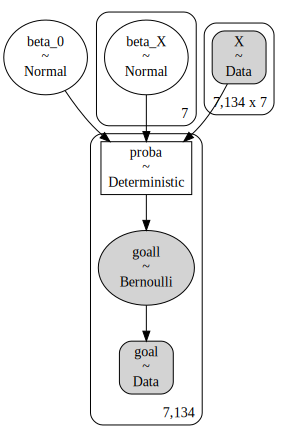

In [38]:
X_obs = dfm[['Distance', 'Angle', 'X', 'Y', 'C']]
X_obs['SqDistance'] = X_obs['Distance']**2
X_obs['DistanceXAngle'] = X_obs['Distance'] * X_obs['Angle']
X_obs = X_obs.values
goal_obs = pd.Categorical(dfm['goal']).codes

with pm.Model() as full_plus_model:
    beta_0 = pm.Normal('beta_0', mu=0, sigma=1.5)
    beta_X = pm.Normal('beta_X', mu=0, sigma=0.05, shape=7)
    
    X = pm.Data('X', X_obs)
    goal_obs = pm.Data('goal', goal_obs)

    mu = beta_0 + pm.math.dot(X, beta_X)
    
    proba = pm.Deterministic('proba', pm.math.sigmoid(mu))
    
    goall = pm.Bernoulli('goall', p=proba, observed=goal_obs)
    
    prior_pred = pm.sample_prior_predictive()

    idata_full_plus = az.from_pymc3(prior=prior_pred)

# idata_full_plus.to_netcdf(DATA_FILEPATH.parent / 'distance_azobj_prior.nc')
pm.model_to_graphviz(full_plus_model)

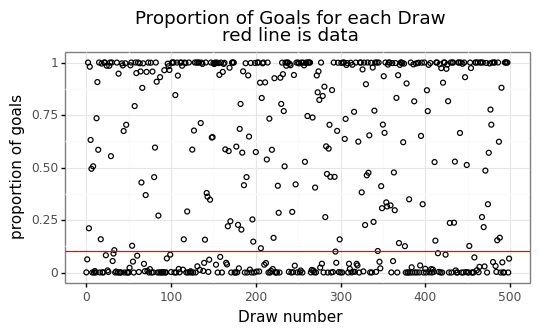

In [39]:
data_propgoal = len(df_orig[df_orig['goal']==1]) / len(df_orig)

goals = idata_full_plus.prior_predictive['goall'].to_dataframe().reset_index()
goals = pd.DataFrame(goals.groupby(by=['draw'])['goall'].sum() / goals.groupby(by=['draw'])['goall'].count()).reset_index()
goals = goals.rename(columns={'goall': 'proportion_goals'}) 
p = (ggplot(goals, aes(x='draw', y='proportion_goals')) +
     geom_point(fill='none') +
     geom_hline(yintercept = data_propgoal, color='red') +
     labs(x='Draw number', y='proportion of goals', title='Proportion of Goals for each Draw\nred line is data') +
     theme(figure_size=(6,3))
    )
p.draw();

In [40]:
n_draws = 1000
# Occasionally getting:
# - The acceptance probability does not match the target.
# - It is 0.xx but should be close to 0.8.
# - Try to increase the number of tuning steps.
# hence lifting tuning 1000 > 2000 and setting seed for reproducibility
n_tune = 2000

with full_plus_model:
    posterior_trace = pm.sample(n_draws, tune=n_tune, return_inferencedata=False, random_seed=1915)
    posterior_predictive = pm.sample_posterior_predictive(posterior_trace)
    idata_full_plus.extend(az.from_pymc3(trace=posterior_trace, posterior_predictive=posterior_predictive))
# idata_distance_angle.to_netcdf(DATA_FILEPATH.parent / 'distance_azobj_posterior.nc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_X, beta_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 946 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


In [41]:
idata_full_plus

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> constant_data

In [42]:
az.loo(idata_full_plus)

Computed from 4000 by 7134 log-likelihood matrix

         Estimate       SE
elpd_loo -1989.06    51.72
p_loo        8.17        -

In [43]:
az.compare({"Distance Model":idata_distance,
            "Distance Angle Model": idata_distance_angle,
            "Full Model": idata_full,
            "Full plus Model": idata_full_plus})

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Full plus Model,0,-1989.063249,8.173364,0.000000,9.164144e-01,51.723281,0.000000,False,log
Full Model,1,-1993.946568,5.674636,4.883319,6.553492e-15,52.135765,2.787755,False,log
Distance Angle Model,2,-1994.113470,3.331303,5.050221,5.733388e-15,51.975502,3.519236,False,log
Distance Model,3,-2013.108159,2.495645,24.044910,8.358559e-02,52.388165,8.043062,False,log


## Predictions
### Posterior Predictive

In [44]:
# with full_plus_model:
#     post_pred = pm.sample_posterior_predictive(posterior_trace)
#     distance_angle_idata.extend(az.from_pymc3(posterior_predictive=post_pred))
# # distance_azobj.to_netcdf(DATA_FILEPATH.parent / 'azobj_posterior_predictive.nc')

In [45]:
# distance_angle_idata

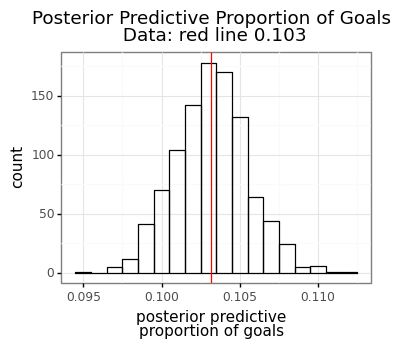

In [46]:
# a bit big -  4 chains x 4000 draws x 7134 (observed) distances.
post_pred_goals = idata_full_plus.posterior_predictive.goall.to_dataframe().droplevel(0)
post_pred_goals_sum = post_pred_goals.groupby(level=0).sum()
post_pred_goals_count = post_pred_goals.groupby(level=0).count()
post_pred_goals_prop = (post_pred_goals_sum / post_pred_goals_count).rename(columns={'goall': 'prob_goal'})

p = (ggplot(post_pred_goals_prop, aes('prob_goal')) +
     geom_histogram(fill='none', color='black', binwidth=0.0010) +
     geom_vline(xintercept=data_propgoal, color='red') +
     xlab("count") +
     xlab("posterior predictive\nproportion of goals") +
     labs(title=f"Posterior Predictive Proportion of Goals\n Data: red line {data_propgoal:.3f}") +
     theme(figure_size=(4, 3))
    )
p.draw();

In [47]:
# az.loo(distance_angle_idata)

In [48]:
# az.waic(distance_angle_idata)

In [49]:
stop

NameError: name 'stop' is not defined

# TODO 

### Apply Model to Unseen data - Distance range
+ Need to get probabilities for an equi-spaced array of distances OR in this case use the quantile cuts, so we can produce a calibration plot of the model predicted probs. vs, the probs calculated from the data
+ Running posterior_predictive_sample will only return goal data, but we are really interested in the underlying probability data
+ Therefore, swap the distances data for the new distances and run sample to get the posterior probabilities.
+ We will use the posterior beta distributions from the trained model to create the new probabilities at the new distances

In [ ]:
n_draws = 1000
shot_distances_range = df_stacked_qcuts[df_stacked_qcuts['variable']=='Distance'].reset_index(drop=True)['midpoint'].values
# Alternate equi-spaced distances - but not set up for reliability plot
# max_distance = int(df_mdist['Distance'].max()) + 5
# shot_distances_range = np.arange(0, max_distance, 1).astype(float)
# n_distances = shot_distances_range.shape[0]
n_distances = shot_distances_range.shape[0]

with distance_anglemodel:    
    # Set the new distances as shot distances
    shot_distances = pm.set_data({'shot_distances': shot_distances_range})
    post_pred = pm.sample_posterior_predictive(posterior_trace,
                                               # var_namesIterable[str]
                                               # Names of variables for which to compute the posterior predictive samples.
                                                var_names=['goall', 'proba', 'beta_0', 'beta_distance'])
    # Create a new object for the oos data
    oos_distance_azobj = az.from_pymc3(posterior_predictive=post_pred)

In [ ]:
oos_distance_azobj

In [ ]:
oos_summ = az.summary(oos_distance_azobj.posterior_predictive, kind='stats')
oos_probs = oos_summ.loc[[l for l in oos_summ.index if 'proba' in l]]
oos_probs['distance'] = shot_distances_range
oos_probs['data_mean_prob'] = df_stacked_qcuts[df_stacked_qcuts['variable']=='Distance']['prob_goal'].values
oos_probs.head()

In [ ]:
az.plot_trace(oos_distance_azobj.posterior_predictive, var_names=['beta_0', 'beta_distance']);

In [ ]:
trace_plots = az.plot_trace(oos_distance_azobj.posterior_predictive, var_names=['proba'], combined=True, compact=True,
                            coords={'chain': oos_distance_azobj.posterior_predictive.proba.chain.values,
                                    'draw': oos_distance_azobj.posterior_predictive.proba.draw.values,
                                    'proba_dim_0': oos_distance_azobj.posterior_predictive.proba.proba_dim_0.values[0:5]})
trace_plots;

In [ ]:
p = (ggplot(oos_probs, aes(x='distance')) +
     geom_pointrange(aes(y='mean', ymax='hdi_97%', ymin='hdi_3%'), fill='none', size=0.3) +
     geom_point(df_stacked_qcuts[df_stacked_qcuts['variable']=='Distance'], aes(x='midpoint', y='prob_goal'), color='red', fill='none', alpha=1.0) +
     labs(x='shot distance',
          y='probability of goal',
          title=f'Posterior Probability of Goal vs Shot Distance\nprobs from binned actual data in red') +
     theme(figure_size=(8, 4))
    )
p.draw();

In [ ]:
p = (ggplot(oos_probs, aes(x='data_mean_prob')) +
     geom_pointrange(aes(y='mean', ymax='hdi_97%', ymin='hdi_3%'), fill='none', size=0.3) +
     geom_abline(intercept=0, slope=1, alpha=0.5) +
     labs(x='actual prob. goal from data',
          y='model predicted probab of goal\nwith 3-97% hdi band',
          title=f'Reliability Plot - Distance Model') +
     theme(figure_size=(4, 4))
    )
p.draw();

In [ ]:
# Placeholder - Calculate ECE for model comparison

### Apply Model to Unseen data - Pitch map

In [ ]:
pitch_shot_distances = dist_pitchmap.flatten()
angle_pitchmap

with distance_model:    
    # Set the pitch distances as the new shot distances data
    shot_distances = pm.set_data({'shot_distances': pitch_shot_distances})
    post_pred = pm.sample_posterior_predictive(posterior_trace,
                                                var_names=['goall', 'proba', 'beta_0', 'beta_distance'])
    # Create a new object for the oos data
    pitch_distance_azobj = az.from_pymc3(posterior_predictive=post_pred)

### Check Model Predictions against Data

In [ ]:
oos_summ = az.summary(pitch_distance_azobj.posterior_predictive, kind='stats')
pitch_probs = oos_summ.loc[[l for l in oos_summ.index if 'proba' in l]]
pitch_probs['distance'] = pitch_shot_distances
pitch_probs['range'] = pitch_probs['hdi_97%'] - pitch_probs['hdi_3%']
pitch_probs.head()

In [ ]:
mean_probs_pitchmap = pitch_probs['mean'].values.reshape((65, 65))
lo_probs_pitchmap = pitch_probs['hdi_3%'].values.reshape((65, 65))
hi_probs_pitchmap = pitch_probs['hdi_97%'].values.reshape((65, 65))
probs_range_pitchmap = pitch_probs['range'].values.reshape((65, 65))

In [ ]:
(fig,ax) = FCPython.createGoalMouth()
vmax = .8
pos=ax.imshow(mean_probs_pitchmap, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.hot_r,vmin=0, vmax=vmax)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title(f'Mean Probability of Scoring')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
(fig,ax) = FCPython.createGoalMouth()
vmax1 = .15
pos=ax.imshow(probs_range_pitchmap, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.hot_r,vmin=0, vmax=vmax1)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title(f'Probability Range of Scoring')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(lo_probs_pitchmap, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.hot_r,vmin=0, vmax=vmax)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title(f'Low end Probability of Scoring')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(hi_probs_pitchmap, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.hot_r,vmin=0, vmax=vmax)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title(f'High end Probability of Scoring')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
min_n_shots = 4
h_shots = H_Shot[0]
h_shots[h_shots < min_n_shots] = 0
prob_goal = H_Goal[0]/h_shots

(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(prob_goal, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.hot_r,vmin=0, vmax=vmax)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title('Actual Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
cal_probs = prob_goal - mean_probs_pitchmap[0:50, 0:50]
(fig,ax) = FCPython.createGoalMouth()
vmax=0.1
pos=ax.imshow(cal_probs, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.hot_r,vmin=0, vmax=vmax)
fig.colorbar(pos, ax=ax, fraction=0.020)
ax.set_title('Difference between Model and Data\nProbability of goal scored from shot at locn.\nProb diff. maxed at 0.1')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show() 